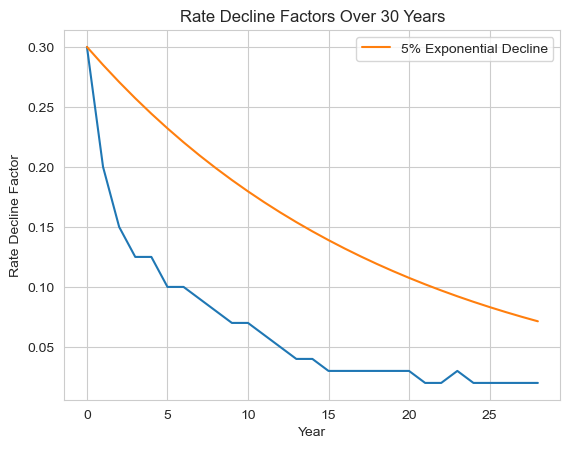

/Users/Tim/Thesis/Thesis/BrandtModelReplication_v0_2.py:334: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '16169.999999999998' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  production_profile_df.loc[year, 'Baseline Raw Gas Rate, MSCFD'] = production_profile_df.loc[year - 1, 'Baseline Raw Gas Rate, MSCFD'] * (1 - rate_decline_factors[year-1])


0     0.583822
1     0.580400
2     0.604799
3     0.514079
4     0.473410
5     0.552269
6     0.543954
7     0.489558
8     0.445498
9     0.409858
10    0.381168
11    0.354486
12    0.333217
13    0.316556
14    0.358631
15    0.381440
16    0.369997
17    0.358897
18    0.348130
19    0.393093
20    0.381300
21    0.369861
22    0.362464
23    0.355215
24    0.344558
25    0.338332
26    0.331565
27    0.324934
28    0.318435
29    0.312066
Name: Baseline GOR, SCF/BBL, dtype: float64
0     0.004959
1     0.004959
2     0.004959
3     0.004959
4     0.004959
5     0.004959
6     0.004959
7     0.004959
8     0.004959
9     0.004959
10    0.004959
11    0.004959
12    0.004959
13    0.004959
14    0.004959
15    0.004959
16    0.004959
17    0.004959
18    0.004959
19    0.004959
20    0.004959
21    0.004959
22    0.004959
23    0.004959
24    0.004959
25    0.004959
26    0.004959
27    0.004959
28    0.004959
29    0.004959
Name: Baseline GOR, SCF/BBL, dtype: float64
Case: Baseli

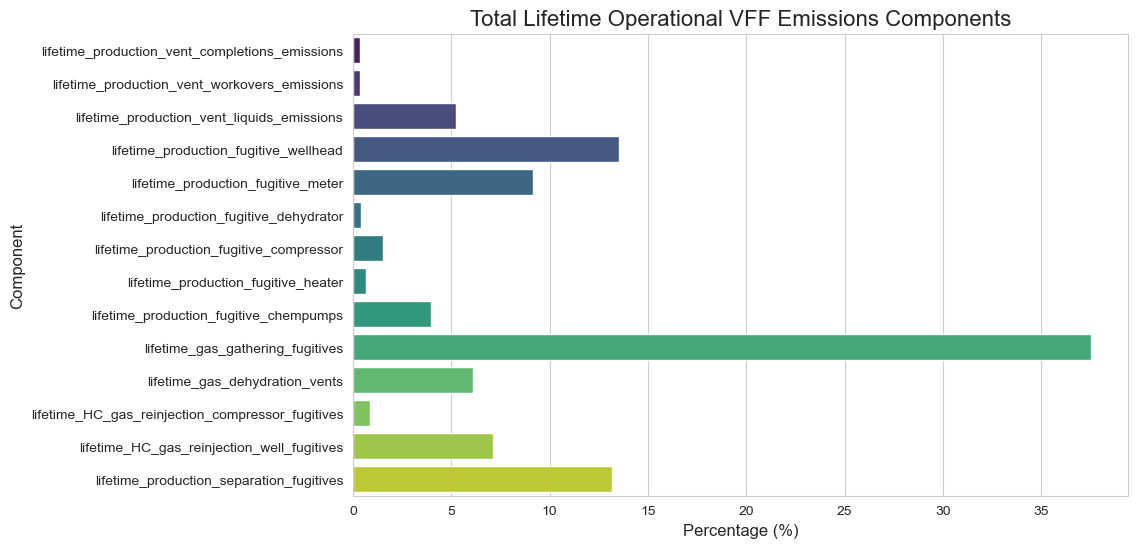

{'case': 'Baseline', 'surface_tubing_total_mass_all_wells': 57534.75, 'surface_tubing_total_mass_brandt': 45662.5}
2538.0
Maximum Gas Flow Rate: 23.1
Minimum Gas Flow Rate: 2.8503209767800843
Absorber Inner Diameter based on max gas flow rate: 57.675115581838114 in
Absorber Inner Diameter based on min gas flow rate: 20.54984979851527 in
27091.96397574401
ID, OD, Height, Rounded Thickness: (19.4, 20.0, 15, 0.6)
Shell Volume: 3719.0173833196036
Total mass of dehydration equipment: 4462.820859983524 lb
Total mass of gas injection equipment: 12720.762080484963 lb
Total mass of PSA unit: 12690.0 lb
Crude transported per lb of steel in US pipeline system: 0.9800648894250515 MMbbl/lb
Total emissions: 0.6814509998591296 kgCO2e/kgH2
{'case': 'Baseline', 'total_lifetime_emissions': 71875307.08553536}
{'case': 'Baseline', 'total_hydrogen_produced': 121524242.57504612}
Total emissions per total amount of hydrogen produced in the lifetime of the field in  Baseline  case: 0.5914483033387307 kgCO2e/k

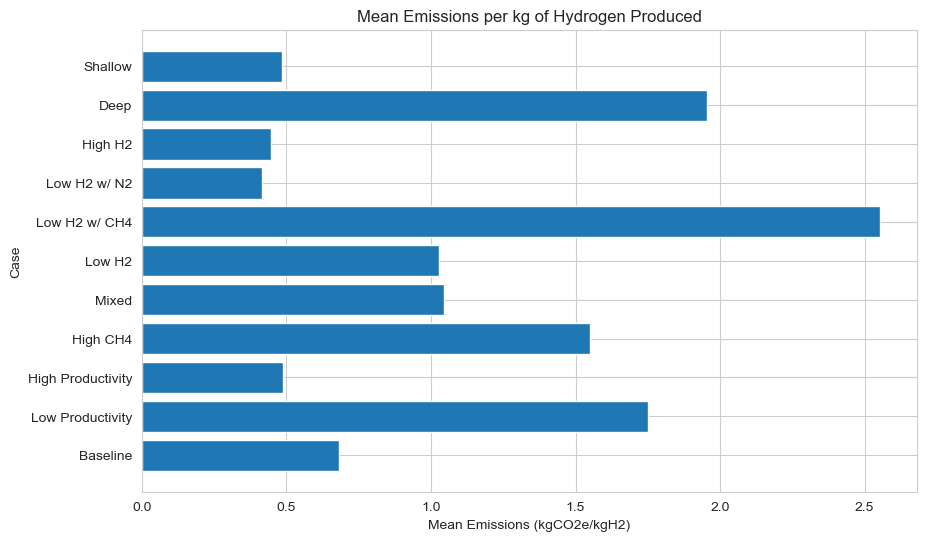

In [1]:
import numpy as np
import pandas as pd
import concurrent.futures
from itertools import repeat
import os
from BrandtModelReplication_v0_2.ipynb import calculate_average_emissions_per_kg_hydrogen

def perform_sensitivity_analysis_parallel(case, sensitivity_variables):
    first_variable = sensitivity_variables[list(sensitivity_variables.keys())[0]]
    N = len(first_variable)
    all_cases = [{key: value[i] for key, value in sensitivity_variables.items()} for i in range(N)]

    # Limit number of processes to avoid overwhelming the system
    num_processes = min(4, os.cpu_count() - 1)  # Adjust number of processes if needed
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_processes) as executor:
        results = list(executor.map(calculate_average_emissions_per_kg_hydrogen, repeat(case), all_cases))

    results_values = [result['average_emissions_per_kg_hydrogen'] for result in results]
    return pd.DataFrame({**sensitivity_variables, 'average_emissions_per_kg_hydrogen': results_values})

# Define the sensitivity analysis assumptions
N = 10  # Number of samples to be generated for the Monte Carlo simulation

# Set the random seed so the results are repeatable
np.random.seed(123)
sensitivity_assumptions = {
    'GWP_H2': np.random.uniform(2, 15, N),
    'oil_production': np.random.uniform(0.01, 10, N),
    'water_production': np.random.uniform(0.01, 10, N),
    'small_source_emissions_percentage': np.random.uniform(1, 15, N),
    'Total Producing Wells': np.random.randint(1, 100, N),
    'Field Life': np.random.randint(5, 50, N),
    'Water Cut (bbl/mmscf)': np.random.uniform(0.01, 10, N),
    'H2 purification loss rate': np.random.uniform(1, 20, N),
    'pressure_decline_rate': np.random.uniform(0.98, 85, N),
    'number_production_wells': np.random.randint(10, 100, N)
}

# Run sensitivity analysis for the 'Baseline' case
sensitivity_results = perform_sensitivity_analysis_parallel('Baseline', sensitivity_assumptions)
print(sensitivity_results['average_emissions_per_kg_hydrogen'])

# Calculate basic statistics for the sensitivity analysis results:
sensitivity_statistics = sensitivity_results['average_emissions_per_kg_hydrogen'].describe()
print(sensitivity_statistics)

# Describe the statistics of sensitivity_assumptions
sensitivity_assumptions_df = pd.DataFrame(sensitivity_assumptions)
sensitivity_assumptions_statistics = sensitivity_assumptions_df.describe()
print(sensitivity_assumptions_statistics)
